## Introductory Machine Learning: Assignment 3

**Deadline:**

Assignment 3 is due Thursday, October 24 at 11:59pm. Late work will not be accepted as per the course policies (see the Syllabus and Course policies on [Canvas](https://canvas.yale.edu).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on [Canvas](https://canvas.yale.edu).  You can also post questions or start discussions on [Ed Discussion](https://edstem.org/us/courses/9209/discussion/). The problems are broken up into steps that should help you to make steady progress.

**Submission:**

Submit your assignment as a .pdf on Gradescope, and as a .ipynb on Canvas. You can access Gradescope through Canvas on the left-side of the class home page. The problems in each homework assignment are numbered. 

Note: 
1. Please **assign each sub-question on Gradescope** correctly. This ensures all questions are visible and helps TAs grade efficiently.
2. Double-check that **your PDF is complete and properly knitted** before submission. Please note that resubmissions after the due date will not be accepted for future assignments.
3. For both text and mathematical answers, please use **markdown blocks** instead of code block notes. This prevents answers from being cut off and improves readability. Also, ensure you run every cell before knitting, as un-run markdown cells may have formatting issues.

To produce the .pdf, please do the following in order to preserve the cell structure of the notebook:  
1.  Go to "File" at the top-left of your Jupyter Notebook
2.  Under "Download as", select "HTML (.html)"
3.  After the .html has downloaded, open it and then select "File" and "Print" (note you will not actually be printing)
4.  From the print window, select the option to save as a .pdf

**Topics**
1. Random forests
2. Principal components analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Problem 1: Identifying factors impacting global life expectancy (25 points)

The Global Health Observatory (GHO) under the World Health Organization (WHO) tracks health status and related factors for all countries. Their life expectancy dataset includes variables like immunization, mortality, and economic and social factors, helping to identify key areas for improving a country’s life expectancy.

<p align="center"> 
  <img src="https://raw.githubusercontent.com/YData123/sds265-fa24/main/assignments/assn3/life_expectancy.png" width="600"> 
</p>

In this problem, we’ll leverage the power of regression decision trees and regression forests random forests to explore the factors influencing life expectancy and predict it. Are you ready to dive into the data and see how we might live longer?

In [3]:
# Load the dataset. Don't change it.
life_expectancy = pd.read_csv("https://raw.githubusercontent.com/YData123/sds265-fa24/main/assignments/assn3/life_expectancy_data.csv")
life_expectancy = life_expectancy.drop(columns = [' thinness  1-19 years', ' thinness 5-9 years', 'under-five deaths ', 'Total expenditure'])
life_expectancy.rename(columns={'Life expectancy ': 'Life expectancy', 'Measles ': 'Measles', ' BMI ': 'BMI',
                                'Diphtheria ': 'Diphtheria', ' HIV/AIDS': 'HIV/AIDS','infant deaths': 'Infant deaths', 'percentage expenditure': 'Percentage expenditure'}, inplace=True)
life_expectancy = life_expectancy.dropna() 
life_expectancy.head()

,Country,Year,Status,Life expectancy,Adult Mortality,Infant deaths,Alcohol,Percentage expenditure,Hepatitis B,Measles,BMI,Polio,Diphtheria,HIV/AIDS,GDP,Population,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,6.0,65.0,0.1,584.259210,33736494.0,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,58.0,62.0,0.1,612.696514,327582.0,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,62.0,64.0,0.1,631.744976,31731688.0,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,67.0,67.0,0.1,669.959000,3696958.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,68.0,68.0,0.1,63.537231,2978599.0,0.454,9.5


You can find the desciption of each column as follows:
- `Country` : Country
- `Year` : Year
- `Status` : Country Developed or Developing status
- `Life expectancy` : Life expectancy in age
- `Adult Mortality` : Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)
- `Infant deaths` : Number of Infant Deaths per 1000 population
- `Alcohol` : Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol) -percentage expenditure: Expenditure on health as a percentage of Gross Domestic Product per capita(%)
- `Percentage expenditure`: Expenditure on health as a percentage of Gross Domestic Product per capita(%)
- `Hepatitis B` : Hepatitis B (HepB) immunization coverage among 1-year-olds (%)
- `Measles` : Measles - number of reported cases per 1000 population
- `BMI` : Average Body Mass Index of entire population
- `Polio` : Polio (Pol3) immunization coverage among 1-year-olds (%)
- `Diphtheria` : Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)
- `HIV/AIDS` : Deaths per 1000 live births HIV/AIDS (0-4 years)
- `GDP` : Gross Domestic Product per capita (in USD)
- `Population` : Population of the country
- `Income composition of resources` : Human Development Index in terms of income composition of resources (index ranging from 0 to 1)
- `Schooling` : Number of years of Schooling(years)

We will focus on the numerical data. We first select the predictor variables X and the response variable 'Life expectancy'. Then we use `train_test_split` to randomly split the data into training and test sets.

In [4]:
# Just run the cell.
life_expectancy = life_expectancy.drop(columns = ['Country', 'Status'])

from sklearn.model_selection import train_test_split
y = life_expectancy['Life expectancy']
X = life_expectancy.drop('Life expectancy', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

### 1.1 Building a simple regression tree

Let's start with two of the predictor variables: `HIV/AIDS` (Deaths per 1 000 live births HIV/AIDS (0-4 years)) and `Income composition of resources` (Human Development Index in terms of income composition of resources). You will *manually* build a regression tree using these two variables step by step. 

#### Problem 1.1.a (3 points)

First, make two scatter plots: 'Life Expectancy' vs. 'HIV/AIDS' and 'Life Expectancy' vs. 'Income Composition of Resources'. 

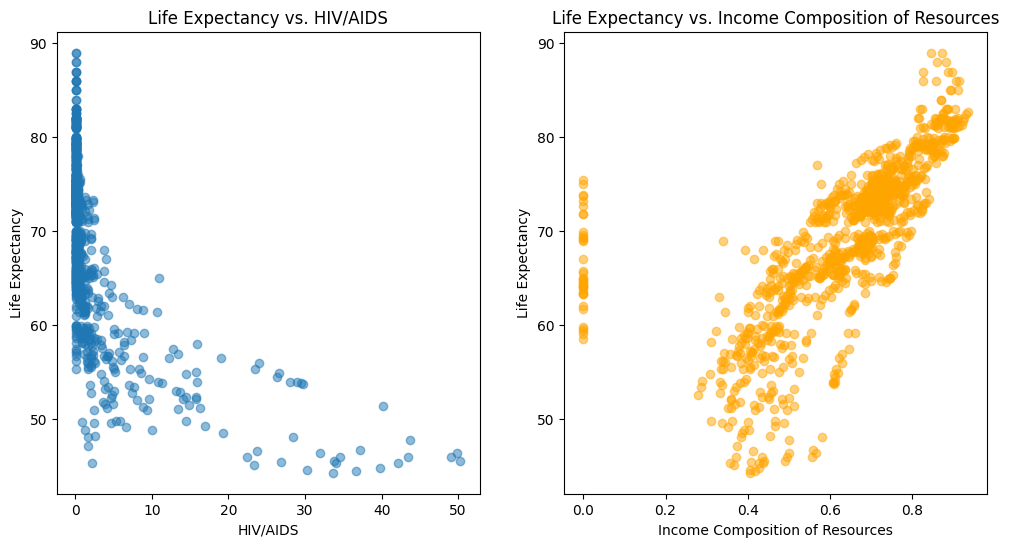

In [6]:
hiv = X_train['HIV/AIDS'].values
income = X_train['Income composition of resources'].values
expectancy = y_train.values

### your code starts here
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(hiv, expectancy, alpha=0.5)
plt.title("Life Expectancy vs. HIV/AIDS")
plt.xlabel("HIV/AIDS")
plt.ylabel("Life Expectancy")

plt.subplot(1, 2, 2)
plt.scatter(income, expectancy, alpha=0.5, color="orange")
plt.title("Life Expectancy vs. Income Composition of Resources")
plt.xlabel("Income Composition of Resources")
plt.ylabel("Life Expectancy")

plt.show()

We can plot Life Expectancy indicated by color using a colormap, and see how life expectancy depends on these two.

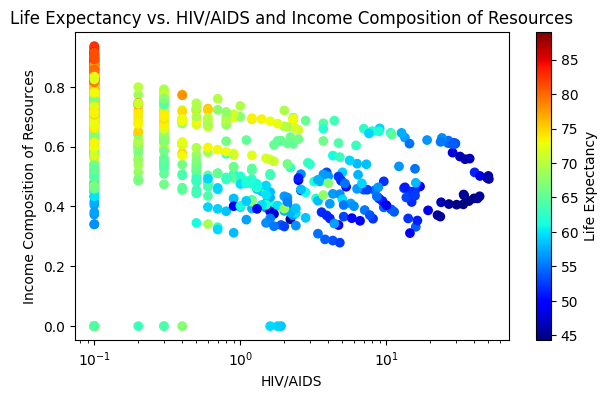

In [7]:
# Just run it, no need to change.
plt.figure(figsize=(7, 4))
scatter = plt.scatter(hiv, income, c=expectancy, cmap='jet')
plt.title('Life Expectancy vs. HIV/AIDS and Income Composition of Resources')
plt.xlabel('HIV/AIDS')
plt.ylabel('Income Composition of Resources')
cbar = plt.colorbar(scatter)
cbar.set_label('Life Expectancy')
plt.xscale("log")
plt.show()

What can you observe from these plots? How do you think this could help in building decision trees? Briefly explain your thoughts in 2-3 sentences.

As deaths per 1000 births HIV/AIDS increases, life expectancy generally increases. And as the income composition of resources increases, life expectancy geenrally increases (except at 0.0). As seen in the life expectancy vs HIV/AIDS and Income Composition of Resources graph, cluster patterns begin to emerge but are not all too distinct, but even just a simple decision tree based on HIV/AIDS and Income Composition of Resources can be effective as a method of regression.

#### Problem 1.1.b (4 Points)

Next, we can define a function to find the best split for a simple regression tree based on a single feature to minimize the mean squared error (MSE). This function is provided for you, and it can be helpful for a fundamental understanding of building a decision tree from scratch.

- feature (np.array): The feature data used for finding the split (e.g. `hiv`).
- target (np.array): The target data used for calculating MSE (e.g. `expectancy`).

Use the `find_best_split` function provided to find the best split and the MSE using 'HIV/AIDS' and 'Income Composition of Resources'. (2 points)

In [8]:
# Don't change it
def find_best_split(feature, target):
    sorted_ind = np.argsort(feature)
    feature_sorted = feature[sorted_ind]
    target_sorted = target[sorted_ind]

    best_mse = float('inf')
    best_split = None

    for i in range(1, len(feature_sorted)):
        if feature_sorted[i] == feature_sorted[i - 1]:
            continue
        split_val = (feature_sorted[i] + feature_sorted[i - 1]) / 2
        left_target = target_sorted[:i]
        right_target = target_sorted[i:]
        left_mse = np.mean((left_target - np.mean(left_target))**2)
        right_mse = np.mean((right_target - np.mean(right_target))**2)
        # Compute weighted average of MSEs
        total_mse = (left_mse * len(left_target) + right_mse * len(right_target)) / len(feature)
        if total_mse < best_mse:
            best_mse = total_mse
            best_split = split_val
    return best_split, best_mse

In [9]:
### your code starts here
best_hiv_split, best_hiv_mse = find_best_split(hiv, expectancy)
print(f"Best Split for HIV/AIDS: {best_hiv_split:.2f}, Best MSE: {best_hiv_mse:.2f}")

best_income_split, best_income_mse = find_best_split(income, expectancy)
print(f"Best Split for Income Composition of Resources: {best_income_split:.2f}, Best MSE: {best_income_mse:.2f}")

Best Split for HIV/AIDS: 0.65, Best MSE: 38.19
Best Split for Income Composition of Resources: 0.63, Best MSE: 37.04


**Which one do you think is the best feature for the first split? Why?** (0 point)

Well it seems like Income Composition of Resources has a lower best MSE, therefore it's the best feature for the first split.

In [10]:
# Run this to see if your answer is correct!
if best_hiv_mse < best_income_mse:
    chosen_name = 'HIV/AIDS'
    another_name = 'Income Composition of Resources'
    chosen_split = best_hiv_split
    chosen_feature = hiv
    another_feature = income
else:
    chosen_name = 'Income Composition of Resources'
    another_name = 'HIV/AIDS'
    chosen_split = best_income_split
    chosen_feature = income
    another_feature = hiv

print(f"Best first split is on {chosen_name} at {chosen_split:.2f}")

Best first split is on Income Composition of Resources at 0.63


We’ve successfully made the first split for our regression tree! The data is now divided into two parts: the left subtree and the right subtree. To grow the tree further, we need to determine which feature to use for splitting the left and right subtrees.

In [11]:
# Just run it. Don't change!
mask = chosen_feature <= chosen_split
left_feature_chosen, left_feature, left_target = chosen_feature[mask], another_feature[mask], expectancy[mask]
right_feature_chosen, right_feature, right_target = chosen_feature[~mask], another_feature[~mask], expectancy[~mask]

left_split, left_mse = find_best_split(left_feature, left_target)
left_split_chosen, left_mse_chosen = find_best_split(left_feature_chosen, left_target)
right_split, right_mse = find_best_split(right_feature, right_target)
right_split_chosen, right_mse_chosen = find_best_split(right_feature_chosen, right_target)

print(f"Left Split for {another_name}: {left_split:.2f}, Best MSE: {left_mse:.2f}")
print(f"Left Split for {chosen_name}: {left_split_chosen:.2f}, Best MSE: {left_mse_chosen:.2f}")
print(f"Right Split for {another_name}: {right_split:.2f}, Best MSE: {right_mse:.2f}")
print(f"Right Split for {chosen_name}: {right_split_chosen:.2f}, Best MSE: {right_mse_chosen:.2f}")

Left Split for HIV/AIDS: 1.35, Best MSE: 27.23
Left Split for Income Composition of Resources: 0.51, Best MSE: 40.22
Right Split for HIV/AIDS: 0.25, Best MSE: 20.18
Right Split for Income Composition of Resources: 0.80, Best MSE: 13.32


**Based on the above results, find the correct feature (`left_name` and `right_name`) and split points for left subtree and right subtree (`left_split` and `right_split`).** (2 points)

In [12]:
### your code starts here, not necessarily one line for each
left_name = "HIV/AIDS"
right_name = "Income Composition of Resources"
left_split = 1.35
right_split = 0.80
print(f"Left Split on {left_name} at {left_split:.2f}. Right Split on {right_name} at {right_split:.2f}")

Left Split on HIV/AIDS at 1.35. Right Split on Income Composition of Resources at 0.80


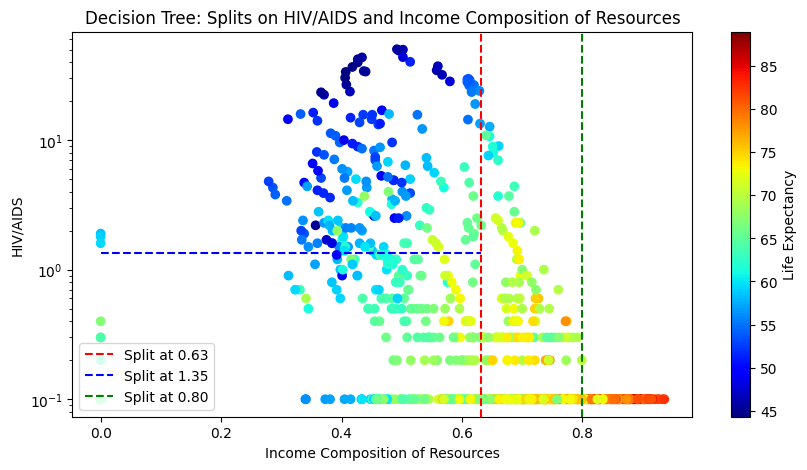

In [13]:
# Run this cell to see the tree you grown!
plt.figure(figsize=(10, 5))
plt.scatter(chosen_feature, another_feature, c=expectancy, cmap='jet')
plt.axvline(x=chosen_split, color='red', linestyle='--', label=f'Split at {chosen_split:.2f}')
if left_name == chosen_name:
    plt.axvline(x=left_split, color='blue', linestyle='--', label=f'Split at {left_split:.2f}')
else:
    plt.hlines(y=left_split, xmin=min(chosen_feature), xmax=chosen_split, colors='blue', linestyle='--', label=f'Split at {left_split:.2f}')
if right_name == chosen_name:
    plt.axvline(x=right_split, color='green', linestyle='--',  label=f'Split at {right_split:.2f}')
else:
    plt.hlines(y=right_split, xmin=chosen_split, xmax=max(chosen_feature), colors='green', linestyle='--',  label=f'Split at {right_split:.2f}')
plt.colorbar(label='Life Expectancy')
plt.xlabel(chosen_name)
plt.ylabel(another_name)
if chosen_name == 'HIV/AIDS':
    plt.xscale("log")
else:
    plt.yscale("log")
plt.legend(loc='lower left')
plt.title('Decision Tree: Splits on HIV/AIDS and Income Composition of Resources')
plt.show()

### 1.2 Fitting a full regression tree (6 Points)

Now build a tree that uses all the predictor variables, has a more flexible structure, and is validated with a test set. Remember that we have split the full dataset into a training set and a test set. Fit a regression tree to the training set using the function `DecisionTreeRegressor` from `sklearn.tree`. For now, use your best judgment to choose parameters for tree complexity. Plot your decision tree use `plot_tree` function.

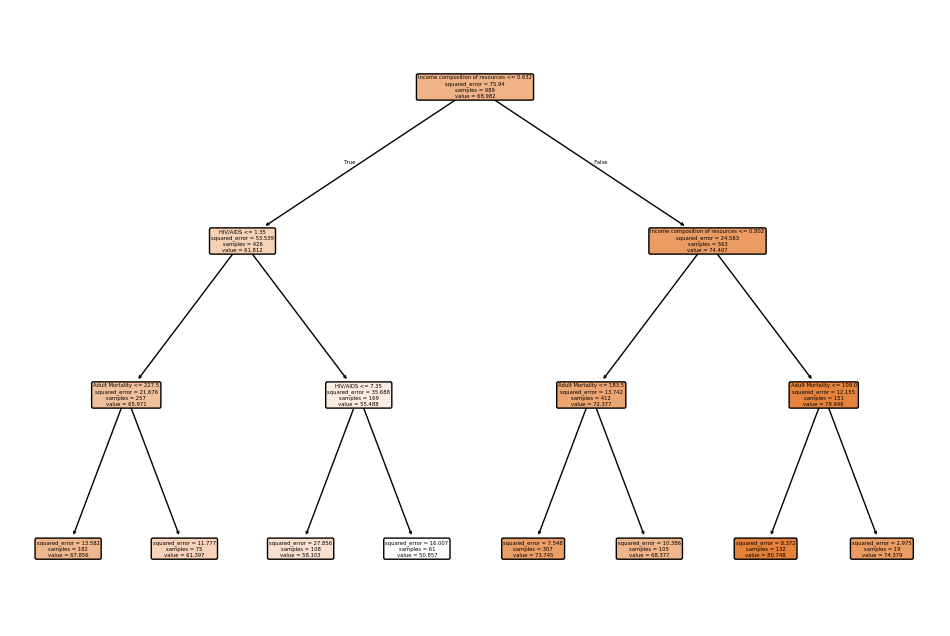

In [15]:
from sklearn import tree

### Your code starts here
# tree parameters go inside the first set of parentheses and the training data
# goes in the second set of parentheses
regressor = tree.DecisionTreeRegressor(max_depth=3, random_state=42)
regressor.fit(X_train, y_train)
plt.figure(figsize=(12, 8))
tree.plot_tree(regressor, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

What can you observe from this tree? If you set the `max_depth = 3`, is it consistant with what you find in problem 1.1b?

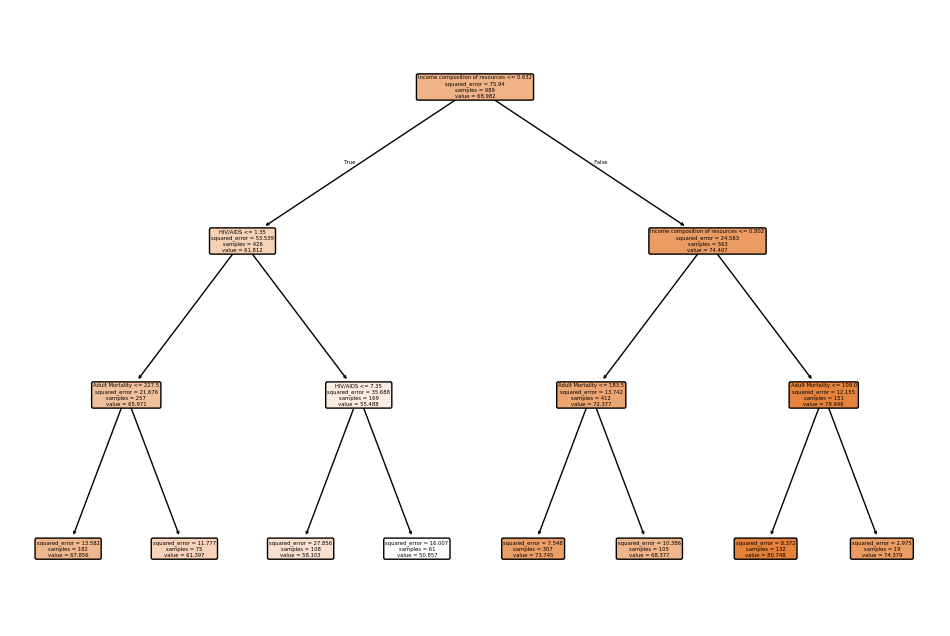

In [20]:
dtree = tree.DecisionTreeRegressor(max_depth=3)
dtree = dtree.fit(X_train, y_train)
### Your code starts here. Plot again!
plt.figure(figsize=(12, 8))
tree.plot_tree(dtree, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

It is consistent with what I found in 1.1b up to depth = 2. It's also observed that Adult Mortality is another good predictor at depth > 2 as it performs better than the two we were dealing with previously in certain cases.

### 1.3 Evaluation of your tree (4 Points)

Evaluate your regression tree with the test dataset. What is the R-squared and the MSE of the model using the test set? The `.predict` method for your model can help with this.

In [21]:
# Making predictions on the test dataset
### Your code starts here
from sklearn.metrics import mean_squared_error, r2_score

y_pred = regressor.predict(X_test)
r_squared = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)

print(f"R-squared for the test set: {r_squared:.2f}")
print(f"Mean Squared Error (MSE): {MSE:.2f}")

print(f"R-squared for the test set: {r_squared:.2f}")
print(f'Mean Squared Error (MSE): {MSE:.2f}') 

R-squared for the test set: 0.84
Mean Squared Error (MSE): 12.36
R-squared for the test set: 0.84
Mean Squared Error (MSE): 12.36


### 1.4 Let's try random forests (8 points)

Finally, we will grow random forests to analyze the data,
using the `RandomForestRegressor` function from `sklearn.ensemble`. Again, please use your best judgment to choose the initial parameters for tree complexity. 
Finish the following code to look at the "out of bag" (OOB) error as we increase the number of trees in the ensemble. (4 points)

100%|██████████| 19/19 [00:46<00:00,  2.47s/it]


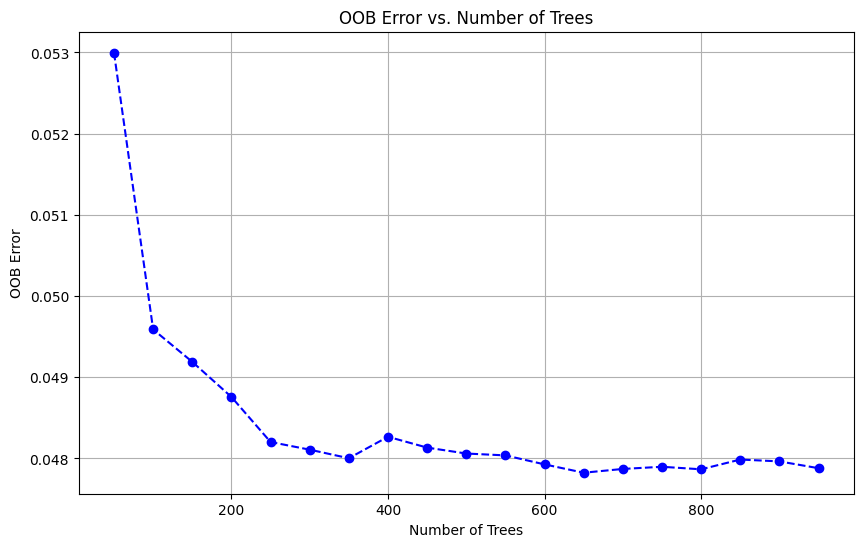

In [22]:
from sklearn import ensemble
from tqdm import tqdm

oob_error = []
num_trees = np.arange(50, 1000, 50)

### Your code starts here
# Initialize Random Forest Regressor with OOB Score enabled

# Loop over the range of number of trees
for m in tqdm(num_trees):
    rf = ensemble.RandomForestRegressor(
        n_estimators=m, oob_score=True, random_state=42, bootstrap=True
    )
    rf.fit(X_train, y_train)
    oob_error.append(1 - rf.oob_score_)
# Plotting the OOB error as the number of trees varies
plt.figure(figsize=(10, 6))
plt.plot(num_trees, oob_error, marker="o", linestyle="--", color="b")
plt.title("OOB Error vs. Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("OOB Error")
plt.grid(True)
plt.show()

Visualize the variable importance of the model, which is the improvement in the loss (Gini index) due to splitting on a given variable, averaged over all of the trees in the forest. (The `.feature_importances_` method of the model may help with this.) (2 points)

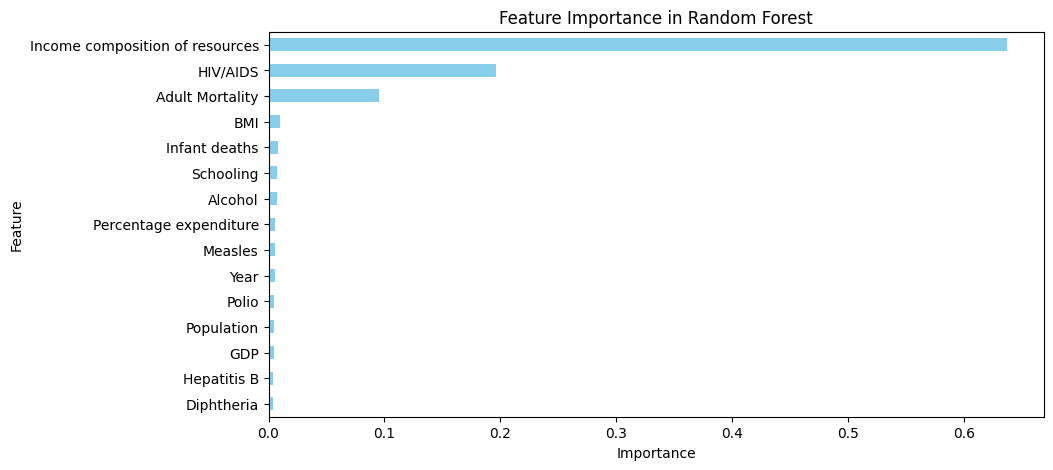

In [23]:
rf.set_params(n_estimators=500)
model = rf.fit(X_test, y_test)
importances = model.feature_importances_

importance_df = pd.DataFrame(
    {"Feature": X_test.columns, "Importance": importances}
).sort_values(by="Importance", ascending=False)

### Your code starts here
fig, ax = plt.subplots(figsize=(10, 5))
importance_df.plot(
    kind="barh", x="Feature", y="Importance", ax=ax, color="skyblue", legend=False
)
ax.set_title("Feature Importance in Random Forest")
ax.set_xlabel("Importance")
ax.set_ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

Answer the following questions to evaluate the performance of random forests: (2 points)

1. Which variables are most important in predicting life expectancy?

1. What test MSE do you obtain, and how does it compare to the test MSE of the regression tree above? 

In [24]:
### Your code starts here
y_rf_pred = model.predict(X_test)

MSE_rf = mean_squared_error(y_test, y_rf_pred)

print(f"Mean Squared Error (MSE) for Random Forest: {MSE_rf:.2f}")
print(
    f"Test MSE from Regression Tree: {MSE:.2f}"
) 
print("Top 5 most important variables in predicting life expectancy:")
print(importance_df.head(5))

Mean Squared Error (MSE) for Random Forest: 0.79
Test MSE from Regression Tree: 12.36
Top 5 most important variables in predicting life expectancy:
                            Feature  Importance
13  Income composition of resources    0.636577
10                         HIV/AIDS    0.195963
1                   Adult Mortality    0.095415
7                               BMI    0.010123
2                     Infant deaths    0.008265


[Your answer starts here]

The most important variables appear to be Income composition of resources, HIV/AIDS, Adult Mortality, BMI, and Infact deaths. We obtained an MSE of 0.79, which is significantly better than that of the regression tree.

# Problem 2: PCA: Penguin Culmen Analysis (20 points)

Let's revisit our flightless friends with the new tools we've learned.

In [ ]:
# run the cell to import needed packages

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# just run this cell to read in the data

df = pd.read_csv('https://github.com/YData123/sds265-fa22/raw/master/assignments/assn2/penguins.csv')
df = df.drop(columns=['index','year','island'])
df = df.dropna(axis=0)

# encode the labels
species = list(set(df['species']))
df['class'] = LabelEncoder().fit_transform(df['species'])
sex = [int(list(df['sex'])[j]=='male') for j in range(len(df))]
df['sex'] = sex
df = df.drop(columns=['species'])

y = np.array(df['class'])
X = df.copy()
X = X.drop(columns=['class'])

In [ ]:
# just run this cell to standardize

for i in range(5):
    X.iloc[:,i] = (X.iloc[:,i]-np.mean(X.iloc[:,i]))/np.std(X.iloc[:,i])

print(f"X is {X.shape[0]} rows with {X.shape[1]} columns.")

### 2.1 Run PCA

In the next cell, carry out Principle Component Analysis to reduce the data from 5 dimensions to 2.

Let `pv1` be the first principal vector and let `pv2` be the second principal vector. Let `pcs` be the projection of the data onto the first two principal vectors.

In [ ]:
# Your code here




pv1 =  # your code here
pv2 =  # your code here
pcs =  # your code here

principalX = pd.DataFrame(data = pcs, columns = ['PC1', 'PC2'])

### 2.2 Principle Component Analysis

The next cell plots the principal vectors.

In [ ]:
# just run this cell

plt.bar(range(5), pv1)
plt.xticks(range(5), X.columns, rotation='vertical')
plt.show()

plt.bar(range(5), pv2)
plt.xticks(range(5), X.columns, rotation='vertical')
plt.show()

Are the first two principle vectors orthogonal? Write code to check and also explain conceptually.

Looking at the plot, what are the first two principle components capturing, in terms of the original features we have?

In [ ]:
# Your code here


[your markdown here]

### 2.3 Visualization

In [ ]:
# just run this cell

plt.scatter(principalX.iloc[:, 0], principalX.iloc[:, 1], c = y)
plt.show()

What is being plotted in this cell above? If you are to add an xlabel and ylabel, what would you call them?

Can you explain why there are pretty much 6 clusters in the plot?

Recall when we plotted using two features of your choice in assignment 2. How are these different and similar?

[your markdoen here]

### 2.4 Visualization with decision boundries

We now want to add the decision boundries to the plot. (Similar to what we did in assignment 2, but this time using the first 2 principle components as x and y.)

In [ ]:
# just run this cell
# the function will again help you plot the decision boundries

def plot_decision_boundaries(X, y, lr, error):
    X2 = np.array(X)
    b = lr.intercept_
    beta = lr.coef_.T
    colors = ['orange', 'pink', 'lightgreen']
    h = 0.015
    x_min, x_max = X2[:, 0].min() - .5, X2[:, 0].max() + .5
    y_min, y_max = X2[:, 1].min() - .5, X2[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(np.c_[xx.ravel(), yy.ravel()], beta) + b
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8,8))
    plt.contourf(xx, yy, Z, levels=[0,.5,1.5,2.5], colors=colors, alpha=0.5)
    for c in range(3):
        mask = (y==c)
        plt.scatter(X2[np.array(mask),0], X2[np.array(mask),1], color=colors[c], label=species[c])

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.legend(loc='upper left')
    plt.title('error rate: %.2f' % error)
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])

In [ ]:
# Your code here


How do you think the model performed comparing to the models you ran in assignment 2?

[Your markdown here]

# Problem 3: PCA Applications -- Faces and Genetics data

In this problem, we will apply PCA to two applications. In the first, we will apply PCA to analyze some face image data and try to understand the variation in this data. In the second application, we will apply PCA to some genetics data and recover an interesting connection with geography!

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

## Problem 3.1: Face image data

In this problem, we will apply implementation of PCA to analyze face image data from the `olivetti_faces` dataset. The dataset consists of $64 \times 64$ greyscale images of faces taken in a controlled setting, varying lighting, facial expressions (eyes open/closed, smiling/not smiling), and facial details (glass / no glasses). The dataset consists of 40 subjects with 10 images for each. It was collected by AT&T between 1992 and 1994.

We will try to understand the variation in face (images) by performing principal component analysis!

First, we fetch the dataset and define a utility function for plotting a gallery of images.

In [ ]:
# this cell fetches the data and defines a function to plot the images

import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

# get data
faces, _ = fetch_olivetti_faces(return_X_y=True)

n_samples, n_features = faces.shape
image_shape = (64, 64)

# define a utility function to plot a gallery of images
def plot_gallery(title, images, n_col=3, n_row=2, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

In [ ]:
# plot first 6 images in dataset
plot_gallery("First 6 images", faces[:6, :])

### Problem 3.1.1: Fit PCA and visualize the top principal vectors

In [ ]:
# fit PCA to the `faces` data. Use `n_components=None` to compute the maximal number of principal vectors
# your code here
pca = ...

In [ ]:
# extract the principal vectors from the fitted PCA object
face_principal_vectors = ... # your code here
plot_gallery("Our EigenFaces", face_principal_vectors)

### Problem 3.1.2: Visualize explained variance of the top $k$ principal vectors

When we compute PCA, we can get the "explained variance" of each principal vector. In this problem, we will visualize the explained variance to better-understand the variation in the data.

Recall that in `sklearn`'s implementation of PCA, the explained variance ratio of the $i$ th principal vector is given by `pca.explained_variance_ratio_[i]`. This is a number between 0 and 1. You can think of this as the percentage of the variation in the data in the direction of the $i$ th principal vector.

Then, we can define the cumulative explained variance of the top $k$ principal vectors as,
$$\mathrm{cumulative\_explained\_variance\_ratio}(k) = \sum_{i=1}^{k} \mathrm{explained\_variance\_ratio}(i).$$

This quantity represents the proportion of the variation in the data which is explained by the first $k$ principal vectors. In this problem, we will plot $k$ against against $\mathrm{explained\_variance\_ratio}(k)$ and $\mathrm{cumulative\_explained\_variance\_ratio}(k)$. This gives us an idea of how many directions account for most of the variation in the data.

------
**Aside**: How is the "explained variance ratio" obtained?

Recall that PCA is computed via the eigenvectors and eigenvalues of the empirical covariance matrix. Let $S$ be the empirical covariance matrix. Then, its eigenvectors $v_i$ are the principal vectors. Denote the eigenvalue of the $i$ th eigenvector by $\lambda_i$. In `sklearn`, the eigenvalues are accessible via `pca.explained_variance_`; $\lambda_i$ is `pca.explained_variance_[i]`. The "explained variance ratio" is a ratio of each eigenvalue to the sum of the eigenvalues. That is, $\mathrm{explained\_variance\_ratio}(i) = \lambda_i / \sum_j \lambda_j$.

The eigenvalue of a particular eigenvector of the covariance matrix will be larger when there is more variation in that direction. The "ratio" part of explained variance simply normalizes these eigenvalues so that they sum to 1, giving the quantity an interpretation as the proportion of the variance explained by a particular direction.

In [ ]:
# plot the explained variance of the top k principal components as a function of k

# extract the explained variance ratio of each principal vector
explained_variance_ratio_per_component = ... # your code here

# compute cumulative explained variance ratio upto k components for each k
cumulative_explained_variance_ratio = ... # your code here (hint: you can use np.cumsum or do the sum yourself)

# plot the explained variance ratio per component and the cumulative explained variance ratio
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
ax1.plot(explained_variance_ratio_per_component)
ax1.set_xlabel('component');
ax1.set_ylabel('explained variance per component');


ax2.plot(cumulative_explained_variance_ratio)
ax2.set_xlabel('number of principal vectors');
ax2.set_ylabel('cumulative explained variance');

Comment on the curve you observe. Roughly how many principal vectors are required to explain 90\% of the variance? What does this tell you about the underlying variation in the data?

[Your markdown here]

### Problem 4.1.3: Reconstructing data from principal components

In this question, we will use PCA to re-construct the face images from fewer principal components. The plots above show that most of the variance in the data is explained by the first few principal components. In this question, we will visualize this by reconstructing a face image using the first $k$ principal components, varying $k$. We will then use the face image PCA to (attempt to) reconstruct an image of an octopus.

Recall that the first $k$ principal components, $v_1, \ldots, v_k$ give an orthonormal basis for a $k$-dimensional subspace of the data. The first $k$ principal components of a point $x \in \mathbb{R}^d$ are given by $\left(v_1^\top (x - \bar{x}), \ldots, v_k^\top (x - \bar{x})\right)$. Each principal component represents the amount of $x$ that lies in the direction of the corresponding principal vector. The principal components can then be used to reconstruct $x$ via,

$$\hat{x} = \bar{x} + \sum_{i=1}^k \left(v_i^\top (x - \bar{x})\right) v_i.$$

This is essentially a projection onto the $k$-dimensional subspace spanned by the principal vectors $v_1, \ldots, v_k$ (after centering by the mean).

In the `sklearn` implementation of PCA, the mean vector $\bar{x}$ is accessible via `pca.mean_` and the principal vectors are accessible by `pca.compnents_`.

Implement a function `project_principal_vectors` which computes $\hat{x}$ for a given $x$, reconstructing a point in terms of the principal vectors.

In [ ]:
def project_principal_vectors(x, principal_vecs, mean_x, k):
    """
    project a data point onto the first k principal vectors

    Parameters
    ----------
    x : np.ndarray of shape (d,)
        test data point
    principal_vecs : np.ndarray of shape (min(d, n), d)
        array of eigenvectors where eig_vecs[i] is the ith eigenvector
    mean_x : np.ndarray of shape (d,)
        the mean vector of the data
    k : int
        number of principal vectors to project onto

    Returns
    -------
    np.ndarray of shape (d,)
        the projection of x onto the first k principal vectors
    """

    # center the data point
    centered_x = ... # your code here

    # compute the projection onto the first k principal components
    projection = mean_x + sum([
        ... # your code here
        for i in range(k)])

    return projection

In [ ]:
# extract mean vector and principal components from fitted PCA object
face_mean_x = ... # your code here
face_principal_vectors = ... # your code here


face = faces[0] # consider the first image in the dataset (you can change this to any image in the dataset)
fig, axs = plt.subplots(figsize=(20,6), ncols=9)

# plot the original image
axs[0].imshow(face.reshape(image_shape), cmap='gray')
axs[0].set_title('original')

for rotated_ax, k in zip(axs[1:], [1, 5, 10, 50, 100, 200, 300, 400]):
    # compute the reconstruction using the first k principal components using `project_principal_vectors`
    reconstruction = ... # your code here

    # plot the reconstructed image using the first k principal components
    rotated_ax.imshow(reconstruction.reshape(image_shape), cmap='gray')
    rotated_ax.set_title(f'k={k}')

What happens if we try to apply our PCA algorithm, which was fitted on images of faces, to an image of something that is not a face? Let's try! Below, we'll attempt to use PCA to reconstruct an image of a cute octopus.

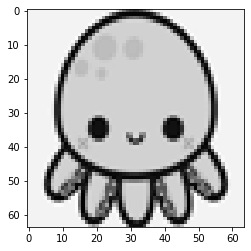

In [4]:
# source of image: "https://i.pinimg.com/originals/6d/dc/5a/6ddc5a4845441a5d93583a8b2f8f562f.jpg"
# the cute_octopus.png file is a cropped, reshaped, and grayscale version of the image
from PIL import Image
import urllib

url = 'https://raw.githubusercontent.com/YData123/sds265-fa24/main/assignments/assn3/cute_octopus.png'
cute_octopus = np.array(Image.open(urllib.request.urlopen(url)))

plt.imshow(cute_octopus, cmap='gray')
cute_octopus = cute_octopus.flatten() # flatten the image into a vector

In [ ]:
# extract mean vector and principal components from PCA object fitted to face data
face_mean_x = ... # your code here
face_principal_vectors = ... # your code here


fig, axs = plt.subplots(figsize=(20,6), ncols=9)

# plot the original image
axs[0].imshow(cute_octopus.reshape(image_shape), cmap='gray')
axs[0].set_title('original')

for rotated_ax, k in zip(axs[1:], [1, 5, 10, 50, 100, 200, 300, 400]):
    # compute the reconstruction using the first k principal components using `project_principal_vectors`
    reconstruction = ... # your code here

    # plot the reconstructed image using the first k principal components
    rotated_ax.imshow(reconstruction.reshape(image_shape), cmap='gray')
    rotated_ax.set_title(f'k={k}')

What do you observe about the reconstruction of the face image? How well do the reconstructed images match the original image at each $k$. What about the reconstruction of the octopus? Why do you think this is what we observe?

[Your markdown here]

## Problem 3.2: Analyzing genetics data

In this sub-problem, we will PCA to analyzing genetics data. The data we will use comes from the [1000 Genomes Project](https://www.internationalgenome.org/).

A single-nucleotide polymorphism is a substitution of a single nucleotide at a specific location in the genome which is present in a sufficiently large segment of the population. An ancestry-informative SNP (AISNP) is a SNP which has significant variation across global populations. There exists a line of work identifying AISNPs. In this problem, we will use 55 AISNPs identified by [Kidd et al.](https://pubmed.ncbi.nlm.nih.gov/24508742/). We have pre-processed this data for you.

In this problem, you will use PCA to visualize and analyze this data.

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [ ]:
# read in the SNP data
snp_data = pd.read_csv('https://raw.githubusercontent.com/YData123/sds265-fa23/main/assignments/assn3/1000genomes_snp_data.csv')
snp_cols = [col for col in snp_data.columns if col.startswith('rs')]
sample_attr_cols = ['pop', 'super_pop', 'gender']
snp_data.head()

In [ ]:
# one-hot encode the SNP data using sklearn's OneHotEncoder for use with PCA
ohe = OneHotEncoder(sparse_output=False)
X = ohe.fit_transform(snp_data[snp_cols].values)

In [ ]:
# fit PCA on the snp data in X; set the number of components to 2
pca = ... # your code here

# compute first two principal components of each sample in X
snp_pcs = ... # your code here

# add the principal components to the snp_data dataframe
snp_data[['PC1', 'PC2']] = ... # your code here

In [ ]:
# plot the principal components in a scatter plot with super population color-coded

fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=snp_data, x='PC1', y='PC2', hue='super_pop', alpha=0.5, ax=ax);

Take a look at this plot and think about any trends you see. Do you see any connection with geography?

Below, we will rotate this plot so that the center of the EUR and AFR samples on the PC plot lie vertically on top of each other.

In [ ]:
# compute mean PC1 and PC2 for each super population
mean_by_superpop = snp_data.groupby('super_pop')[['PC1', 'PC2']].mean()
afr_pc_mean = mean_by_superpop.loc['AFR'].to_numpy()
eur_pc_mean = mean_by_superpop.loc['EUR'].to_numpy()

# compute angle between center of AFR and EUR clusters
angle = np.arctan2(eur_pc_mean[1] - afr_pc_mean[1], eur_pc_mean[0] - afr_pc_mean[0])
print(f'angle between AFR and EUR principal components: {angle:.2f} radians')

In [ ]:
def create_rotation_mat(angle):
    '''creates 2D rotation matrix for given angle'''
    c, s = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array(((c, -s), (s, c)))
    return rotation_matrix

# rotate the principal components by the angle between the AFR and EUR clusters
rotation_mat = create_rotation_mat(angle - np.pi/2)
rotated_pcs = snp_data[['PC1', 'PC2']].to_numpy() @ rotation_mat

# create lines denoting the principal components in the rotated axes
pc1_line = [(pc1, 0) for pc1 in ax.get_xlim()]
pc2_line = [(0, pc2) for pc2 in ax.get_ylim()]
pc1_line_rotated = pc1_line @ rotation_mat
pc2_line_rotated = pc2_line @ rotation_mat

In [ ]:
# plot rotated principal components
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=rotated_pcs[:, 0], y=rotated_pcs[:, 1], hue=snp_data['super_pop'], alpha=0.5);
ax.plot(pc1_line_rotated[:,0], pc1_line_rotated[:,1], color='black', linestyle='--', label='PC1');
ax.plot(pc2_line_rotated[:,0], pc2_line_rotated[:,1], color='black', linestyle='--', label='PC2');

For reference, below is a cartogram of the global population from wikipedia. It shows a map of the world with land area scaled according to population.


<img src="https://upload.wikimedia.org/wikipedia/commons/9/90/Global_population_cartogram.png" width=1000px/>

Comment on any patterns you observe. Are "super populations" which are geographically closer also closer in terms of their first two principal components? Can you suggest any explanations for the patterns you observe?

[Your markdown here]